# Index
<font size = 3>

0. <a href="#item0">Imports</a>

1. <a href="#item1">Data Preparation</a>

2. <a href="#item2">Data Cleaning</a>

3. <a href="#item3">Using Google Places API</a>

4. <a href="#item4">Exploratory Data Analysis</a>

5. <a href="#item5">Four Square API</a>
    
6. <a href="#item6">Clustering</a>

</font>
</div>

<br><br><br>
<a id='item0'></a> 
# Imports

In [33]:
import requests
import json # to parse the json file

import pandas as pd # because arrays are oldschool (to create dataframes)
from pandas.io.json import json_normalize # for handling nested json
import matplotlib.cm as cm
import matplotlib.colors as colors
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import numpy as np

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from progressbar import ProgressBar
import time # for delay

from GoogleMapsApiKey import get_key
import FoursquareApiCredentials as fs

import folium
from folium.plugins import MarkerCluster

from IPython.display import clear_output # to clear notebook output cell via code

print('Libraries Imported')

Libraries Imported


<br><br><br>
<a id='item1'></a> 
# 1. Data Preparation


In [ ]:
with open('collegeList.json') as jsonFile: # refers to the json we created while scraping the website
    raw_data = json.load(jsonFile) # load data to a python variable
print('Data Imported.')

In [ ]:
df = json_normalize(raw_data) # normalizing the data using pandas library function

In [ ]:
df

### Sub-Key 'venues' is nested inside of info, so we normalize it using json_normalize()

In [ ]:
venues = json_normalize(data = raw_data, record_path = 'venues')
venues.drop('display_area', axis = 1, inplace = True) # this column serves no purpose whatsoever

### Lets check if we successfully extracted the venues data

In [ ]:
df.columns

In [ ]:
venues

In [ ]:
df = df.join(venues) # Merging df and venues

<br><br><br><br>
<a id='item2'></a> 
# 2. Data Cleaning

In [ ]:
df.columns # lets revise the columns we have

In [ ]:
# We seriously dont need these columns they are just clutter that we got from json we parsed
columns_to_drop = ['degree', 'density.fulltime', 'density.parttime', 
    'enhanced', 'organisation_id', 'level', 'listing_type', 'logo', 'methods.blended',
    'methods.face2face', 'methods.online','parttime_duration.unit', 
    'parttime_duration.value', 'summary', 'title', 'venues', 'fulltime_duration.value', 'fulltime_duration.unit']
df.drop(columns_to_drop, axis = 1,inplace = True)

In [ ]:
df.isna().sum()

In [ ]:
df[df['tuition_fee.currency'] != 'EUR'].count()

In [ ]:
df = df[df['tuition_fee.currency'].notnull()] #new df from current df where tuition_fee.currency is not null 
df = df[df['area'].notnull()]

According to https://www.geteducated.com/career-center/detail/what-is-a-masters-degree,
To earn a master’s degree you usually need to complete from 36 to 54 semester credits of study (or 60 to 90 quarter-credits). This equals 12 to 18 college courses. 

45 is average of 36 ad 54!

In [ ]:
df.loc[df['tuition_fee.unit'] == 'credit', 'tuition_fee.value'] = (df['tuition_fee.value']*45)/2 
# Multiplying tuition_fee.value by 45 when tuition_fee.unit is 'credit' 
# This gives us average per year fees, to get a uniform fee scale (all fees in per year format)

In [ ]:
df.drop(['tuition_fee.currency', 'tuition_fee.unit'], axis=1, inplace=True) 
# since we have uniform values we dont need the currency and unit thus we will drrop them

In [ ]:
df = df.rename(columns = {'tuition_fee.value': 'fees', 'organisation': 'college_name'})

In [ ]:
# rearranging the columns
df = df[['id','college_name', 'fees', 'area', 'city', 'country']] # removed location from here on date 20191023

In [ ]:
df

In [ ]:
df = df.reset_index()
df.drop(['index'], axis=1, inplace=True)

<br><br><br>

In [ ]:
df_test = pd.DataFrame()
df_test['clg_city'] = df['college_name'].map(str)+', '+df['city']

In [ ]:
clg_names = df['college_name'].to_list()
clg_city = df_test['clg_city'].to_list()

<br><br><br>
<a id='item3'></a> 
# 3. Using Google Places API

In [ ]:
show_progress = ProgressBar()

In [ ]:
API_KEY = get_key()

In [ ]:
def findPlace(query, key):
    url = 'https://maps.googleapis.com/maps/api/place/findplacefromtext/json?'
    req = requests.get(
        url + 
        'input='  + query +
        '&inputtype='+ 'textquery' +
        '&fields=' + 'geometry/location'+
        '&key=' + key
    ) 
    time.sleep(0.02)
    return req

In [ ]:
def jdump_latlongG(filename, query_list, key):
    with open(filename, 'a+') as jsonFile:
        for i in show_progress(range(0, 2060)):
            req = findPlace(query_list[0][i], key)
            if req.json()['status'] != 'OK':
                req = findPlace(query_list[1][i], key)
            json.dump(req.json(), jsonFile)            

In [ ]:
jdump_latlongG('G-lat-long.json', [clg_city, clg_names], API_KEY)

<br><br><br>
# Importing latitudes and longitudes from json

In [ ]:
with open('G-lat-long-new.json') as jsonFile: # refers to the json we created earlier
    ll_data = json.load(jsonFile) # load data to a python var
print('Lat-Long Imported.')

In [ ]:
ll = json_normalize(ll_data, record_path='candidates', meta =['status'])

In [ ]:
ll.drop('formatted_address', axis=1, inplace=True)
ll.rename(columns={'geometry.location.lat': 'latitude', 'geometry.location.lng': 'longitude'})
ll.shape

<br>

<br>

## Making new columns in df from ll dataframe

<br>

In [ ]:
df = df.join(ll)

In [ ]:
df.shape

In [ ]:
df = df[df['status']=="OK"]

In [ ]:
df.drop(['status'], axis=1, inplace=True)
df = df.rename(columns={'geometry.location.lat': 'latitude', 'geometry.location.lng': 'longitude'})
df.head()

In [ ]:
df.to_csv('college_dataset.csv')

<br>

## We have saved the data to college_dataset.csv 

<br>


In [ ]:
df = pd.read_csv("college_dataset.csv") 

In [ ]:
df.head()

In [ ]:
df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [ ]:
df['country'].value_counts()

In [ ]:
df = df[df['country'].str.contains("United States|United Kingdom|Canada")] 
# keeping only the locations with location-country as US, UK, Canada

In [ ]:
# manually checked lat long on google maps
df['latitude'][df.college_name=='University of California, Berkeley'] = 37.8718992
df['longitude'][df.college_name=='University of California, Berkeley'] = -122.2607286

df['latitude'][df.college_name=='Johnson & Wales University'] = 41.8197902
df['longitude'][df.college_name=='Johnson & Wales University']= -71.415209

In [ ]:
# They are placed in india and nowhere found on google maps
df.drop(df[df['college_name']=='Engineering and Technology College'].index, inplace = True)
df.drop(df[df['college_name']=='College of Nursing and Public Health'].index, inplace = True)

In [ ]:
df[df['fees']>50000]

In [ ]:
# Manually searched college fees
df['fees'][df.college_name=='University of Colorado at Boulder'] = 48570
df['fees'][df.college_name=='University of Pennsylvania'] = 7134
df['fees'][df.college_name=='University of Nebraska Omaha'] = 28564
df['fees'][df.college_name=='Johns Hopkins University'] = 45350
df['fees'][df.college_name=='University of Illinois at Urbana Champaign'] = 53437
df['fees'][df.college_name=='Carnegie Mellon University'] = 38940
df['fees'][df.college_name=='Northwestern University'] = 42000
df['fees'][df.college_name=='Washington University in St. Louis'] = 63000
df['fees'][df.college_name=='University of Massachusetts Amherst'] = 62000
df['fees'][df.college_name=='Bentley University'] = 68640

In [ ]:
df.reset_index(drop=True, inplace=True)

In [ ]:
df.to_csv('final_college_dataset.csv')

<br><br><br>

<a id='item4'></a> 
# 4. Exploratory Data Analysis

So now that we have our data it's time to explore it. Lets see the number per country. The venues data frame would make it easy to do so.

In [2]:
df = pd.read_csv("final_college_dataset.csv")

In [3]:
df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [4]:
df_usa=df[df['country'].str.contains("United States")]
df_uk=df[df['country'].str.contains("United Kingdom")]
df_canada=df[df['country'].str.contains("Canada")]

<br><br>
## Lets look at the geospatial data

In [5]:
usa_coordinates = [37.0902, -100]
canada_coordinates = [54.6959279, -90]
uk_coordinates = [54.2186138, -5]

<br><br>
## USA Map

In [6]:
usa_map = folium.Map(location = usa_coordinates, zoom_start = 4)
mc = MarkerCluster().add_to(usa_map)    

for row in df_usa.itertuples():
    folium.Marker(
        location=[row.latitude,row.longitude],
        icon = None,
        popup=row.college_name
    ).add_to(mc)

usa_map

<br><br>
## Canada Map

In [7]:
canada_map = folium.Map(location = canada_coordinates, zoom_start = 4)
mc = MarkerCluster().add_to(canada_map)    

for row in df_canada.itertuples():
    folium.Marker(
        location=[row.latitude,row.longitude],
        icon = None,
        popup=row.college_name
    ).add_to(mc)

canada_map

<br><br>
## UK Map

In [8]:
uk_map = folium.Map(location = uk_coordinates, zoom_start = 6)
mc = MarkerCluster().add_to(uk_map)    

for row in df_uk.itertuples():
    folium.Marker(
        location=[row.latitude,row.longitude],
        icon = None,
        popup=row.college_name
    ).add_to(mc)

uk_map

<br><br>
# Lets Take a look at the salary

In [9]:
df.describe()

id          fees     latitude    longitude
count    2034.000000   2034.000000  2034.000000  2034.000000
mean   158242.061455  21496.101032    43.465296   -58.660623
std     87511.264137   9907.860290     7.933261    43.554852
min       597.000000    371.000000    21.296939  -157.817112
25%     81069.500000  15342.000000    38.765159   -89.252071
50%    152929.000000  20331.000000    41.924756   -76.603588
75%    247536.000000  26166.000000    51.521970    -2.465706
max    287854.000000  68640.000000    64.855757     1.239176

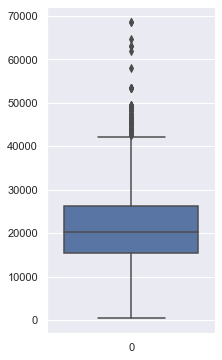

In [10]:
sns.set(rc={'figure.figsize':(3,6)})
boxplot = sns.boxplot(data=df['fees'])

## Let's look at average fees by country

In [11]:
print('Average fees per country')
print("USA : {0:.2f}".format(df_usa['fees'].mean()))
print("UK : {0:.2f}".format(df_uk['fees'].mean()))
print("Canada : {0:.2f}".format(df_canada['fees'].mean()))

Average fees per country
USA : 22592.21
UK : 20467.31
Canada : 10897.81


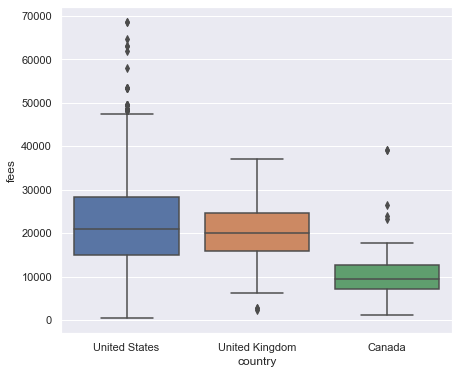

In [12]:
sns.set(rc={'figure.figsize':(7,6)})
boxplot = sns.boxplot(
    data = df,
    x = 'country',
    y = 'fees'
)

# Note: 

## The box plot of Canada lies within th 50% Quartile range of USA, it won't be surprising if we get more <font color = 037ffc>canadian colleges</font> when looking for similar <font color = 037ffc>low fees</font> colleges when holding money as a criterion.

## Similarly, <font color = 037ffc>UK</font> would be a preffered choice when choosing <font color = 037ffc>mid to high fees </font>colleges when compared to USA when holding money as a criterion.

## It is obvious, but let me specifically point out, <font color = 'red'>USA has the highest fees</font> in all 3 nations.

<br><br><br>
<a id='item5'></a> 
# 5. FourSquare Places API

In [13]:
CLIENT_ID = fs.get_client_id() # your Foursquare ID
CLIENT_SECRET = fs.get_client_secret() # your Foursquare Secret
VERSION = '20181102' # Foursquare API version
RADIUS = 10000 # Radius to search in
LIMIT = 20 # Limit to no. of search results

In [14]:
def getNearbyVenues(names, latitudes, longitudes, radius=10000):
    count = 0
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(count, name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        try:
            results = requests.get(url).json()["response"]['groups'][0]['items']
            venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['shortName']) for v in results])
        
        except KeyError:
            print('KeyError: Replacing with none.')
            venues_list.append([name, lat, lng, None, None, None, None])
        count += 1
    
    return(venues_list)

In [15]:
college_venues = getNearbyVenues(names=df['college_name'],
                                   latitudes=df['latitude'],
                                   longitudes=df['longitude']
                                  )

0 School of Nursing and Health Professions
1 Kogod School of Business, American University Washington DC
2 University at Buffalo, The State University of New York  School of Engineering and Applied Sciences
3 School of Management
4 University of South Wales
5 Middlesex University
6 University of Northampton
7 Gannon University
8 Royal Holloway University of London
9 Wright State University
10 Teesside University
11 Staffordshire University
12 Roosevelt University
13 George Mason University
14 University of South Wales
15 Pace University
16 University of the Pacific - International
17 George Mason University
18 University of Birmingham
19 Marist College
20 George Mason University
21 Manchester Metropolitan University
22 George Mason University
23 University of the West of England (UWE Bristol)
24 University of Texas Arlington
25 Marist College
26 Middlesex University
27 Wichita State University
28 Coventry University
29 University of South Wales
30 Northumbria University London Campus
3

In [16]:
none_list = []
for i in range(len(college_venues)+1):
    try:
        if college_venues[i][-1] == None:
            none_list.append(i)
    except:
        pass
none_list

[250,
 499,
 521,
 544,
 547,
 602,
 619,
 620,
 776,
 797,
 851,
 870,
 1160,
 1292,
 1466,
 1889]

In [17]:
not_none = []
for i in range(len(college_venues)):
    if i not in none_list:
        not_none.append(college_venues[i])
    else:
        pass
not_none   

[[('School of Nursing and Health Professions',
   37.7765665,
   -122.45030870000001,
   'The Booksmith',
   37.76982126220134,
   -122.44936311785642,
   'Bookstore'),
  ('School of Nursing and Health Professions',
   37.7765665,
   -122.45030870000001,
   'Haight Street Market',
   37.77000455429876,
   -122.44763416560943,
   'Supermarket'),
  ('School of Nursing and Health Professions',
   37.7765665,
   -122.45030870000001,
   'Workshop.',
   37.777438452809925,
   -122.44156203405919,
   'Arts & Crafts'),
  ('School of Nursing and Health Professions',
   37.7765665,
   -122.45030870000001,
   'Amoeba San Francisco',
   37.76904270486288,
   -122.45258415810717,
   'Record Shop'),
  ('School of Nursing and Health Professions',
   37.7765665,
   -122.45030870000001,
   'The Independent',
   37.77557274879696,
   -122.43783539145652,
   'Rock Club'),
  ('School of Nursing and Health Professions',
   37.7765665,
   -122.45030870000001,
   'Fool’s Errand',
   37.77551224062072,
   -12

In [19]:
nearby_venues = pd.DataFrame([item for venue_list in not_none for item in venue_list])
nearby_venues.columns = ['college_name', 
                  'c_latitude', 
                  'c_longitude', 
                  'venue', 
                  'v_latitude', 
                  'v_longitude', 
                  'v_category']

In [20]:
df.drop(none_list)

id                                       college_name     fees  \
0     173294           School of Nursing and Health Professions  29047.5   
1     127982  Kogod School of Business, American University ...  35730.0   
2     152893  University at Buffalo, The State University of...  20857.0   
3     262046                               School of Management  21419.0   
4     104991                          University of South Wales  15514.0   
...      ...                                                ...      ...   
2029   61571                   Florida International University  20362.5   
2030  107225                           University of Cincinnati   5774.0   
2031  125952                         San Diego State University   8075.0   
2032  261320                                             Rdi Uk   6638.0   
2033   98012                  Rochester Institute of Technology  41100.0   

                  area               city         country   latitude  \
0           California      San Francisco   United States  37.776567   
1     Washington, D.C.  Washington, D. C.   United States  38.938340   
2             New York            Buffalo   United States  43.002837   
3              England             London  United Kingdom  51.522407   
4                Wales         Pontypridd  United Kingdom  51.589239   
...                ...                ...             ...        ...   
2029           Florida         West Miami   United States  25.756310   
2030              Ohio         Cincinnati   United States  39.132922   
2031        California          San Diego   United States  32.775722   
2032           England           Coventry  United Kingdom  52.377252   
2033          New York          Rochester   United States  43.084589   

       longitude  
0    -122.450309  
1     -77.087635  
2     -78.787595  
3      -0.131678  
4      -3.330827  
...          ...  
2029  -80.375719  
2030  -84.514950  
2031 -117.071889  
2032   -1.463007  
2033  -77.674344  

[2018 rows x 8 columns]

In [21]:
nearby_venues.groupby('college_name').count()

c_latitude  c_longitude  \
college_name                                                              
Aberystwyth University                                 120          120   
Acadia University                                       20           20   
Albany College of Pharmacy and Health Sciences          20           20   
Alliant International University                        20           20   
American National University                            40           40   
...                                                    ...          ...   
Wrexham Glyndwr University                              60           60   
Wright State University                                 60           60   
Yale University                                         80           80   
Yeshiva University                                      40           40   
York St John University                                 20           20   

                                                venue  v_latitude  \
college_name                                                        
Aberystwyth University                            120         120   
Acadia University                                  20          20   
Albany College of Pharmacy and Health Sciences     20          20   
Alliant International University                   20          20   
American National University                       40          40   
...                                               ...         ...   
Wrexham Glyndwr University                         60          60   
Wright State University                            60          60   
Yale University                                    80          80   
Yeshiva University                                 40          40   
York St John University                            20          20   

                                                v_longitude  v_category  
college_name                                                             
Aberystwyth University                                  120         120  
Acadia University                                        20          20  
Albany College of Pharmacy and Health Sciences           20          20  
Alliant International University                         20          20  
American National University                             40          40  
...                                                     ...         ...  
Wrexham Glyndwr University                               60          60  
Wright State University                                  60          60  
Yale University                                          80          80  
Yeshiva University                                       40          40  
York St John University                                  20          20  

[629 rows x 6 columns]

In [22]:
print('There are {} uniques categories.'.format(len(nearby_venues['v_category'].unique())))

There are 386 uniques categories.


<br><br><br>
<a id='item6'></a> 
# 6. Clustering

In [23]:
nearby_onehot = pd.get_dummies(nearby_venues[['v_category']], prefix="", prefix_sep="")

# add college_name column back to dataframe
nearby_onehot['college_name'] = nearby_venues['college_name'] 

# move college_name column to the first column
fixed_columns = [nearby_onehot.columns[-1]] + list(nearby_onehot.columns[:-1])
nearby_onehot = nearby_onehot[fixed_columns]

nearby_onehot.head()

college_name  ATM  Academic Building  \
0  School of Nursing and Health Professions    0                  0   
1  School of Nursing and Health Professions    0                  0   
2  School of Nursing and Health Professions    0                  0   
3  School of Nursing and Health Professions    0                  0   
4  School of Nursing and Health Professions    0                  0   

   Accessories  Administrative Building  Advertising Agency  Afghan  African  \
0            0                        0                   0       0        0   
1            0                        0                   0       0        0   
2            0                        0                   0       0        0   
3            0                        0                   0       0        0   
4            0                        0                   0       0        0   

   Airport  Airport Service  ...  Whisky Bar  Wine Bar  Wine Shop  Winery  \
0        0                0  ...           0         0          0       0   
1        0                0  ...           0         0          0       0   
2        0                0  ...           0         0          0       0   
3        0                0  ...           0         0          0       0   
4        0                0  ...           0         0          0       0   

   Wings  Women's Store  Yoga Studio  Yogurt  Zoo  Zoo Exhibit  
0      0              0            0       0    0            0  
1      0              0            0       0    0            0  
2      0              0            0       0    0            0  
3      0              0            0       0    0            0  
4      0              0            0       0    0            0  

[5 rows x 387 columns]

In [24]:
nearby_grouped = nearby_onehot.groupby('college_name').mean().reset_index()
nearby_grouped

college_name  ATM  Academic Building  \
0                            Aberystwyth University  0.0                0.0   
1                                 Acadia University  0.0                0.0   
2    Albany College of Pharmacy and Health Sciences  0.0                0.0   
3                  Alliant International University  0.0                0.0   
4                      American National University  0.0                0.0   
..                                              ...  ...                ...   
624                      Wrexham Glyndwr University  0.0                0.0   
625                         Wright State University  0.0                0.0   
626                                 Yale University  0.0                0.0   
627                              Yeshiva University  0.0                0.0   
628                         York St John University  0.0                0.0   

     Accessories  Administrative Building  Advertising Agency  Afghan  \
0            0.0                      0.0                 0.0     0.0   
1            0.0                      0.0                 0.0     0.0   
2            0.0                      0.0                 0.0     0.0   
3            0.0                      0.0                 0.0     0.0   
4            0.0                      0.0                 0.0     0.0   
..           ...                      ...                 ...     ...   
624          0.0                      0.0                 0.0     0.0   
625          0.0                      0.0                 0.0     0.0   
626          0.0                      0.0                 0.0     0.0   
627          0.0                      0.0                 0.0     0.0   
628          0.0                      0.0                 0.0     0.0   

     African  Airport  Airport Service  ...  Whisky Bar  Wine Bar  Wine Shop  \
0        0.0      0.0              0.0  ...         0.0      0.00       0.00   
1        0.0      0.0              0.0  ...         0.0      0.00       0.00   
2        0.0      0.0              0.0  ...         0.0      0.05       0.00   
3        0.0      0.0              0.0  ...         0.0      0.00       0.00   
4        0.0      0.0              0.0  ...         0.0      0.00       0.00   
..       ...      ...              ...  ...         ...       ...        ...   
624      0.0      0.0              0.0  ...         0.0      0.00       0.00   
625      0.0      0.0              0.0  ...         0.0      0.00       0.00   
626      0.0      0.0              0.0  ...         0.0      0.00       0.00   
627      0.0      0.0              0.0  ...         0.0      0.00       0.05   
628      0.0      0.0              0.0  ...         0.0      0.00       0.00   

     Winery  Wings  Women's Store  Yoga Studio  Yogurt  Zoo  Zoo Exhibit  
0       0.0    0.0            0.0         0.00   0.000  0.0          0.0  
1       0.0    0.0            0.0         0.00   0.000  0.0          0.0  
2       0.0    0.0            0.0         0.05   0.000  0.0          0.0  
3       0.0    0.0            0.0         0.00   0.000  0.0          0.0  
4       0.0    0.0            0.0         0.00   0.025  0.0          0.0  
..      ...    ...            ...          ...     ...  ...          ...  
624     0.0    0.0            0.0         0.00   0.000  0.0          0.0  
625     0.0    0.0            0.0         0.00   0.000  0.0          0.0  
626     0.0    0.0            0.0         0.00   0.000  0.0          0.0  
627     0.0    0.0            0.0         0.00   0.000  0.0          0.0  
628     0.0    0.0            0.0         0.00   0.000  0.0          0.0  

[629 rows x 387 columns]

In [25]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [26]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['college_name']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
nearby_venues_sorted = pd.DataFrame(columns=columns)
nearby_venues_sorted['college_name'] = nearby_grouped['college_name']

for ind in np.arange(nearby_grouped.shape[0]):
    nearby_venues_sorted.iloc[ind, 1:] = return_most_common_venues(nearby_grouped.iloc[ind, :], num_top_venues)

nearby_venues_sorted.head()

college_name 1st Most Common Venue  \
0                          Aberystwyth University                 Hotel   
1                               Acadia University                  Café   
2  Albany College of Pharmacy and Health Sciences                  Café   
3                Alliant International University            Sandwiches   
4                    American National University              American   

  2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
0             Bookstore               Italian             Fast Food   
1           Coffee Shop               Brewery                 Hotel   
2         Deli / Bodega            Sandwiches          New American   
3               Brewery                 Sushi            Vietnamese   
4           Supermarket           Coffee Shop               Brewery   

  5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
0         Mediterranean                  Café             Surf Spot   
1       Farmer's Market            Sandwiches         Movie Theater   
2                  Park               Burgers                   Bar   
3                  Lake               Burgers             Juice Bar   
4             Fast Food                 Pizza             Cosmetics   

  8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
0                 Beach                   Bar                Library  
1              Pharmacy             Ice Cream             Restaurant  
2            Vietnamese               Mexican              Ice Cream  
3                Korean         Gym / Fitness                Falafel  
4            Steakhouse                Donuts                 Bakery

In [27]:
from sklearn.cluster import KMeans

In [28]:
# set number of clusters
kclusters = 5

nearby_grouped_clustering = nearby_grouped.drop('college_name', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(nearby_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([4, 1, 4, 4, 4, 0, 4, 3, 4, 4])

In [29]:
# add clustering labels
nearby_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

nearby_merged = df

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
nearby_merged = nearby_merged.join(nearby_venues_sorted.set_index('college_name'), on='college_name')

nearby_merged.head() # check the last columns!

id                                       college_name     fees  \
0  173294           School of Nursing and Health Professions  29047.5   
1  127982  Kogod School of Business, American University ...  35730.0   
2  152893  University at Buffalo, The State University of...  20857.0   
3  262046                               School of Management  21419.0   
4  104991                          University of South Wales  15514.0   

               area               city         country   latitude   longitude  \
0        California      San Francisco   United States  37.776567 -122.450309   
1  Washington, D.C.  Washington, D. C.   United States  38.938340  -77.087635   
2          New York            Buffalo   United States  43.002837  -78.787595   
3           England             London  United Kingdom  51.522407   -0.131678   
4             Wales         Pontypridd  United Kingdom  51.589239   -3.330827   

   Cluster Labels 1st Most Common Venue 2nd Most Common Venue  \
0             4.0                Bakery             Bookstore   
1             4.0           Zoo Exhibit         Mediterranean   
2             4.0                  Café            Steakhouse   
3             4.0                 Hotel                 Pizza   
4             3.0                   Pub                Castle   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0                Garden             Rock Club          New American   
1         National Park               Seafood                  Park   
2           Supermarket               Gourmet                  Arts   
3             Bookstore                   Pub            Steakhouse   
4         Grocery Store            Portuguese           Coffee Shop   

  6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0           Supermarket                Market                   Bar   
1                 Tacos                  Café                 Trail   
2               Mexican              Cineplex         Grocery Store   
3                Lounge          Liquor Store                Museum   
4            Restaurant              Cineplex        Discount Store   

  9th Most Common Venue 10th Most Common Venue  
0             Gift Shop            Cheese Shop  
1                Church          Grocery Store  
2              Japanese                    Gym  
3              Cocktail            Coffee Shop  
4                 Rugby                   Park

In [42]:
nearby_merged[nearby_merged['Cluster Labels'].isnull()]

id                 college_name     fees  area        city  \
619  196671  Youngstown State University  10938.0  Ohio  Youngstown   

           country   latitude  longitude  Cluster Labels  \
619  United States  41.106641 -80.648095             NaN   

    1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
619                   NaN                   NaN                   NaN   

    4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
619                   NaN                   NaN                   NaN   

    7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
619                   NaN                   NaN                   NaN   

    10th Most Common Venue  
619                    NaN

In [43]:
nearby_merged.drop(619, inplace=True)

In [47]:
# create map
map_clusters = folium.Map(location=usa_coordinates, zoom_start=1)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(nearby_merged['latitude'], nearby_merged['longitude'], nearby_merged['college_name'], nearby_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster-1)],
        fill=True,
        fill_color=rainbow[int(cluster-1)],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters